In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
import math
import seaborn as sns
from tqdm import tqdm
from scipy.fft import rfft , rfftfreq , irfft
import soundfile as sf
import os
import soundfile as sf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dense,LSTM,Dropout,BatchNormalization
from keras import layers
from sklearn import preprocessing

In [8]:
df = pd.read_csv("Final Dataframe.csv")

df = df[(df["Emotions"] != "calm") &
        (df["Emotions"] != "surprise")]


Y = df["Emotions"]
df_train, df_test = train_test_split(df, test_size=0.20, random_state=26 , stratify = Y)
df_train, df_val = train_test_split(df_train, test_size=0.20, random_state=26)

print("Train:" , df_train.shape[0])
print("Validation:" , df_val.shape[0])
print("Test:" , df_test.shape[0])

Train: 7243
Validation: 1811
Test: 2264


In [9]:
print("\tTRAIN")
print(df_train["Emotions"].value_counts())
print("\tVALIDATION")
print(df_val["Emotions"].value_counts())
print("\tTEST")
print(df_test["Emotions"].value_counts())

	TRAIN
angry      1258
happy      1236
fear       1230
sad        1219
disgust    1210
neutral    1090
Name: Emotions, dtype: int64
	VALIDATION
disgust    328
sad        320
fear       308
happy      302
angry      280
neutral    273
Name: Emotions, dtype: int64
	TEST
happy      385
angry      385
disgust    385
fear       385
sad        384
neutral    340
Name: Emotions, dtype: int64


In [10]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std()+0.050, signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal


def get_mfcc(audio , sr , num_mfcc=15 , n_fft=2048 , hop_length=512 , plot = False):
    mfcc = librosa.feature.mfcc(y=audio , sr=sr , n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    del_mfcc = librosa.feature.delta(mfcc)
    del2_mfcc = librosa.feature.delta(mfcc, order = 2)
    features = np.concatenate([mfcc , del_mfcc, del2_mfcc])
    
    
    if (plot == True):
        librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("MFCC coefficients")
        plt.colorbar()
        plt.title("MFCCs")

        # show plots
        plt.show()
        
    return features.T

def get_audio_features(path , mfcc_coeff = 15 , max_duration = 154628 , to_plot = False) :
    
    clip,sr = librosa.load(path)

    if (clip.shape[0] < max_duration):
        while(clip.shape[0] < max_duration):
            padding = clip[ : max_duration - clip.shape[0]]
            clip = np.append(clip , padding)
        
    elif(clip.shape[0] > max_duration):
        clip = clip[:154628]
        
    data = get_mfcc(np.array(clip),sr, num_mfcc = mfcc_coeff , plot = to_plot) 
    return np.array(data)

In [11]:
df_train

,Emotions,Path
3440,sad,Datasets/CREMA-D/AudioWAV/1025_IWW_SAD_XX.wav
1775,angry,Datasets/CREMA-D/AudioWAV/1005_IEO_ANG_MD.wav
9376,angry,Datasets/TESS/OAF_angry/OAF_came_angry.wav
7422,happy,Datasets/CREMA-D/AudioWAV/1074_IEO_HAP_HI.wav
3016,happy,Datasets/CREMA-D/AudioWAV/1020_ITS_HAP_XX.wav
...,...,...
401,fear,Datasets/RAVDESS/Actor_07/03-01-06-02-01-02-07...
7029,neutral,Datasets/CREMA-D/AudioWAV/1069_ITH_NEU_XX.wav
9769,fear,Datasets/TESS/OAF_Fear/OAF_boat_fear.wav
10253,neutral,Datasets/TESS/OAF_neutral/OAF_lose_neutral.wav


In [12]:
og_data = []
for path in tqdm(df_train["Path"]):
    data = get_audio_features(path = path)
    og_data.append(data)
    
X_train = np.array(og_data) 
np.save("OG Training Data - Extracted Features - MFCC_15" , X_train)

100%|██████████████████████████████████████████████████████████████████████████████| 7243/7243 [07:38<00:00, 15.79it/s]


In [13]:
val_data = []
for path in tqdm(df_val["Path"]):
    data = get_audio_features(path = path)
    val_data.append(data)
    
X_val = np.array(val_data) 
np.save("OG Validation Data - Extracted Features - MFCC_15" , X_val)

100%|██████████████████████████████████████████████████████████████████████████████| 1811/1811 [02:01<00:00, 14.89it/s]


In [14]:
test_data = []
for path in tqdm(df_test["Path"]):
    data = get_audio_features(path = path)
    test_data.append(data)
    
X_test = np.array(test_data) 
np.save("OG Test Data - Extracted Features - MFCC_15" , X_test)

100%|██████████████████████████████████████████████████████████████████████████████| 2264/2264 [02:41<00:00, 14.00it/s]


In [15]:
# X_train = np.load("Training Data - Extracted Features - MFCC_15.npy")
y_train = df_train["Emotions"] 

# X_val = np.load("Validation Data - Extracted Features - MFCC_15.npy")
y_val = df_val["Emotions"]

one_hot_encoder = preprocessing.LabelBinarizer()
one_hot_encoder.fit(df_train["Emotions"].unique())

y_train = one_hot_encoder.transform(y_train)
y_val = one_hot_encoder.transform(y_val)


In [16]:
print("Train:" , X_train.shape)
print("Val:" , X_val.shape)
print("Classes:" , len(one_hot_encoder.classes_))
input_shape = X_train.shape[1:]
print("Input Shape:" , input_shape)
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
print("\n\nNum GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Train: (7243, 303, 45)
Val: (1811, 303, 45)
Classes: 6
Input Shape: (303, 45)


Num GPUs Available:  1


In [19]:
model = keras.Sequential()
model.add(LSTM(50,input_shape=input_shape , return_sequences=True))
model.add(LSTM(25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(len(one_hot_encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 303, 50)           19200     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_5 (Dense)             (None, 50)                1300      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 30)                1530      
                                                                 
 dense_7 (Dense)             (None, 20)                620       
                                                                 
 batch_normalization_1 (Batc  (None, 20)              

In [20]:
model.compile(optimizer='adam',loss='CategoricalCrossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=500, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/100
15/15 [==============================] - 7s 207ms/step - loss: 1.9144 - accuracy: 0.1923 - val_loss: 1.7767 - val_accuracy: 0.1927
Epoch 2/100
15/15 [==============================] - 2s 123ms/step - loss: 1.7659 - accuracy: 0.2114 - val_loss: 1.7774 - val_accuracy: 0.2623
Epoch 3/100
15/15 [==============================] - 2s 127ms/step - loss: 1.7130 - accuracy: 0.2228 - val_loss: 1.7732 - val_accuracy: 0.2584
Epoch 4/100
15/15 [==============================] - 2s 123ms/step - loss: 1.6860 - accuracy: 0.2355 - val_loss: 1.7701 - val_accuracy: 0.2904
Epoch 5/100
15/15 [==============================] - 2s 125ms/step - loss: 1.6558 - accuracy: 0.2574 - val_loss: 1.7642 - val_accuracy: 0.2617
Epoch 6/100
15/15 [==============================] - 2s 126ms/step - loss: 1.6360 - accuracy: 0.2728 - val_loss: 1.7565 - val_accuracy: 0.2523
Epoch 7/100
15/15 [==============================] - 2s 126ms/step - loss: 1.6060 - accuracy: 0.2950 - val_loss: 1.7491 - val_accuracy: 0.2562

Epoch 58/100
15/15 [==============================] - 2s 124ms/step - loss: 1.0285 - accuracy: 0.5745 - val_loss: 1.3513 - val_accuracy: 0.4727
Epoch 59/100
15/15 [==============================] - 2s 123ms/step - loss: 1.0358 - accuracy: 0.5775 - val_loss: 1.4178 - val_accuracy: 0.4395
Epoch 60/100
15/15 [==============================] - 2s 123ms/step - loss: 1.0742 - accuracy: 0.5607 - val_loss: 1.4674 - val_accuracy: 0.4754
Epoch 61/100
15/15 [==============================] - 2s 124ms/step - loss: 1.0349 - accuracy: 0.5743 - val_loss: 1.3564 - val_accuracy: 0.5080
Epoch 62/100
15/15 [==============================] - 2s 125ms/step - loss: 1.0187 - accuracy: 0.5848 - val_loss: 1.4276 - val_accuracy: 0.4710
Epoch 63/100
15/15 [==============================] - 2s 125ms/step - loss: 1.0193 - accuracy: 0.5850 - val_loss: 1.3043 - val_accuracy: 0.5030
Epoch 64/100
15/15 [==============================] - 2s 123ms/step - loss: 0.9931 - accuracy: 0.5996 - val_loss: 1.3542 - val_accuracy:

In [21]:
y_test = df_test["Emotions"]
y_test = one_hot_encoder.transform(y_test)

from sklearn.metrics import classification_report as cr

y_prob = model.predict(X_test) 
y_pred = y_prob.argmax(axis=-1)
y_true = y_test.argmax(axis=-1)
print(cr(y_true, y_pred , target_names=one_hot_encoder.classes_))

71/71 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

       angry       0.74      0.67      0.70       385
     disgust       0.65      0.24      0.35       385
        fear       0.40      0.54      0.46       385
       happy       0.39      0.70      0.50       385
     neutral       0.60      0.40      0.48       340
         sad       0.62      0.57      0.60       384

    accuracy                           0.52      2264
   macro avg       0.57      0.52      0.52      2264
weighted avg       0.57      0.52      0.52      2264



In [153]:
def plot(y ,sr , title =""):
#     y, sr = librosa.load(librosa.ex('choice'), duration=15)
#     plt.figure()
    fig, ax = plt.subplots(nrows=2, ncols=1 , figsize=(10, 15))
#     print(ax)
    hop_length = 512
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),ref=np.max)
    img = librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,x_axis='time' , ax = ax[1])
    ax[1].set(title='Log-Frequency Power Spectrogram')
    ax[1].label_outer()
    fig.colorbar(img, format="%+2.f dB")
    
    X = rfft(y)
    X_mag = np.absolute(X)
    f = np.linspace(0,sr, len(X_mag))
    ax2 = plt.subplot(211)
#     print(ax)
    ax2.set(title='Frequency Domain Representation')
    plt.plot(f, X_mag) # magnitude spectrum
    plt.xlabel('Frequency (Hz)')
    plt.show()
    
    
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal


def time_stretch(signal, time_stretch_rate):
    """Time stretching implemented with librosa:
    https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
    """
    return librosa.effects.time_stretch(signal, time_stretch_rate)


def pitch_shift(signal, sr, num_semitones):
    """Pitch scaling implemented with librosa:
    https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
    """
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=num_semitones)


def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = np.random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal


def time_shift_with_gaussian(signal , sr , name ,label , save_path ,avg_time_shift_by=4):
    
    shift_by = np.random.normal(sr/avg_time_shift_by , sr/4)  #0.25 seconds
    
    wav_roll = np.roll(signal , int(shift_by))
    aug_signal = add_white_noise(wav_roll , 0.25)
    
    file_name = name[:-4] + "_TimeShifted_" + str(round(len(signal)/shift_by , 2)) + ".wav"
    file_category = label
    print("\n\n\t\tTIME SHIFT WITH GAUSSIAN NOISE\n")
    plot(aug_signal , sr , title = "TIME SHIFT WITH GAUSSIAN NOISE")
    print("\n\n\t\tNEW RAW WAVEFORM\n")
    librosa.display.waveshow(aug_signal,sr=sr)
    plt.title("New Waveform")
    plt.show()
#     sf.write(save_path + file_name, aug_signal, sr, 'PCM_24')

    return file_name,file_category
        
def augment_signal(signal , sr , name ,label , save_path = "Audios - Train/",pitch_shifts=1 ,pitch_shift_by=4,time_shift_factor=4):

    file_names = []
    file_emotions = []
    i = 1
    while(i <= pitch_shifts):
        pitch_shifted_signal_1 = random_gain(pitch_shift(signal , sr , (i+pitch_shift_by)))
        pitch_shifted_signal_2 = random_gain(pitch_shift(signal , sr , -(i+pitch_shift_by)))
        print("\n\n\t\tPITCH SHIFT WITH RANDOM GAIN\n")
        plot(pitch_shifted_signal_1 , sr)
        
        file_name_1 = name[:-4] + "_PitchShiftRG_H" + str(i) + ".wav"
        file_name_2 = name[:-4] + "_PitchShiftRG_L" + str(i) + ".wav"
        
        file_names_pss1,file_emotions_pss1 = time_shift_with_gaussian(pitch_shifted_signal_1 , sr , file_name_1 , label , save_path, time_shift_factor)
        file_names_pss2,file_emotions_pss2 = time_shift_with_gaussian(pitch_shifted_signal_2 , sr , file_name_2 , label , save_path, time_shift_factor)
        
        file_names.append(save_path + file_names_pss1)
        file_names.append(save_path + file_names_pss2)
        file_emotions.append(file_emotions_pss1)
        file_emotions.append(file_emotions_pss2)
        i+=1
        
    return file_names,file_emotions
        
    
    
def augment_signal_time_invariance(signal , sr , name ,label , save_path = "Audios - Train/",avg_time_shift_by=5):
    new_file_names = []
    new_file_categories = []
    
    i=5
    while (i>0):
        
        file_name,file_category = time_shift_with_gaussian(signal , sr , name , label , save_path, avg_time_shift_by)
        
        new_file_names.append(save_path + file_name)
        new_file_categories.append(label)
        
        i-=1
        
    return new_file_names, new_file_categories
    


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

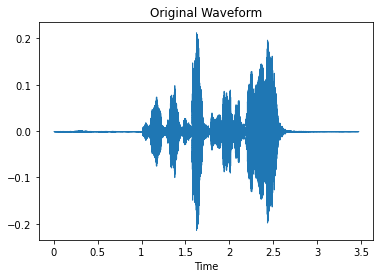

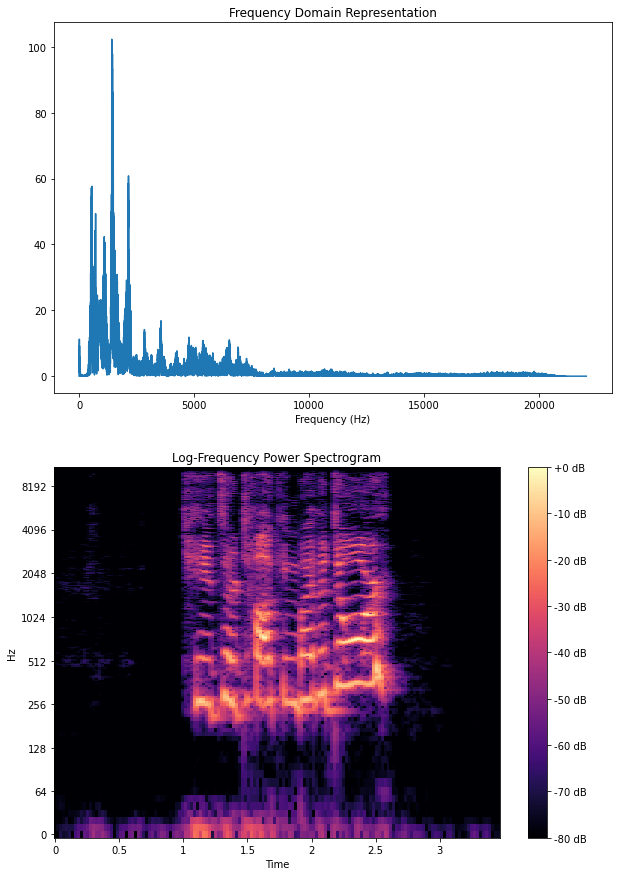



		PITCH SHIFT WITH RANDOM GAIN



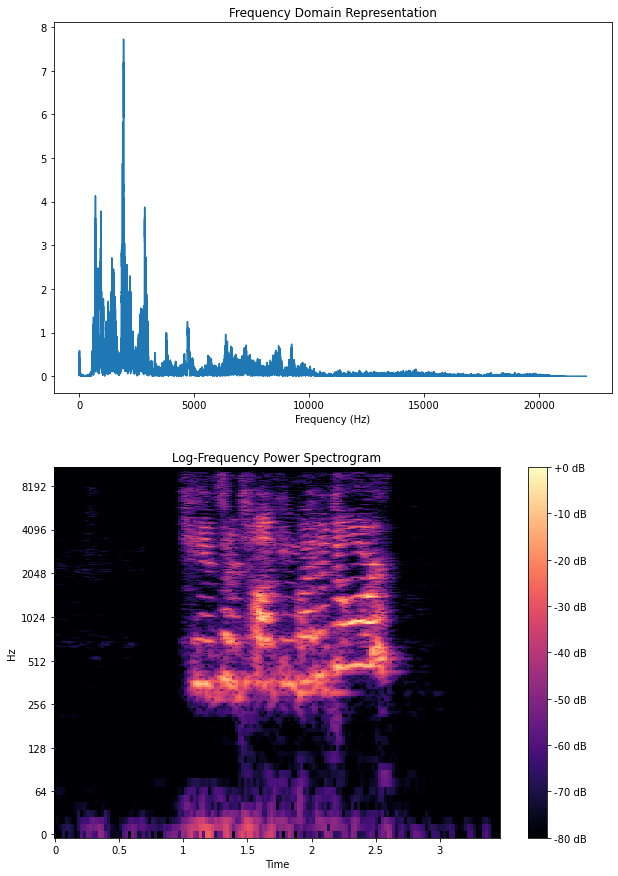



		TIME SHIFT WITH GAUSSIAN NOISE



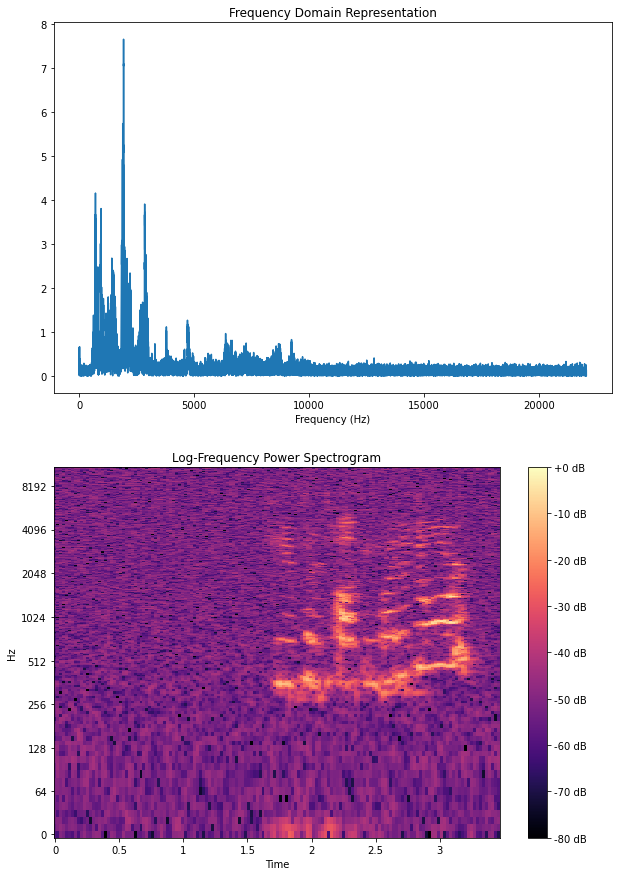



		NEW RAW WAVEFORM



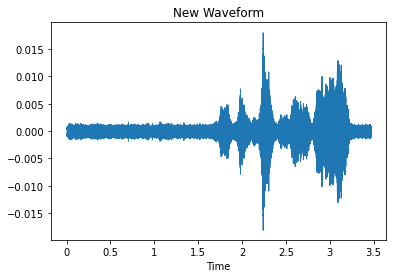



		TIME SHIFT WITH GAUSSIAN NOISE



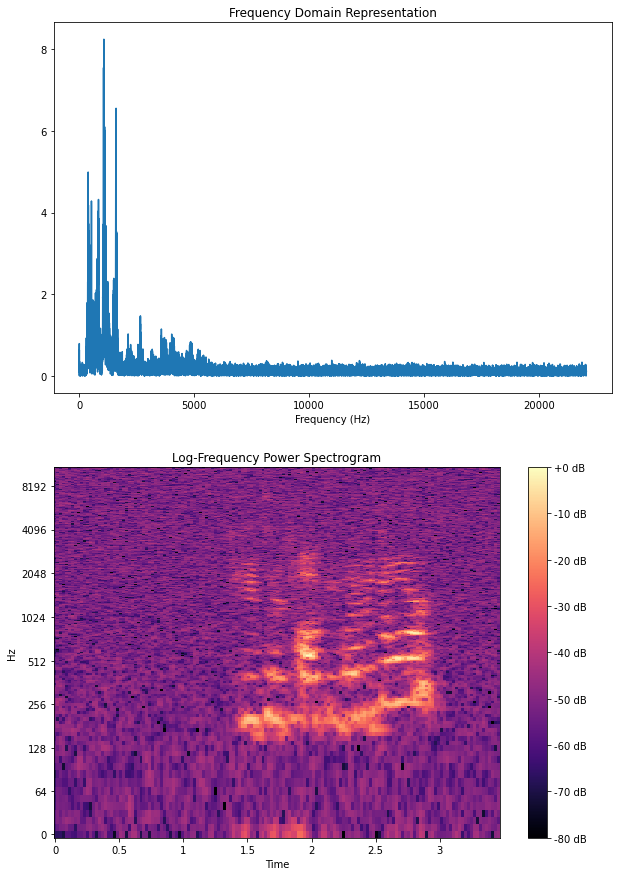



		NEW RAW WAVEFORM



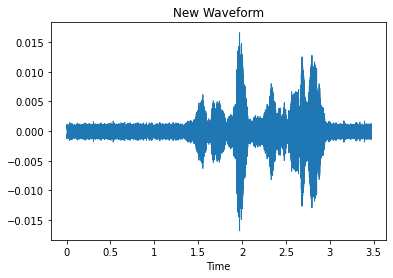

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/it]


In [154]:
save_path = "Audios - Train 1/"
new_file_paths = []
new_labels = []
df_train = df_train.reset_index(drop = True)
for i,label in enumerate(tqdm(df_train["Emotions"][4:5])):
    
    path = df_train.iloc[7238]["Path"]
    signal,sr = librosa.load(path)
    

    librosa.display.waveshow(signal,sr=sr)
    plt.title("Original Waveform")
    plt.show()
    
    plot(signal,sr , title = "ORIGINAL WAVEFORM")
    
    name = path[path.rfind("/")+1:]
#     sf.write(save_path + name, signal, sr, 'PCM_24')
    new_file_paths.append(save_path + name)
    new_labels.append(label)
    
    file_names , file_emotions = augment_signal(signal , sr ,"Aug_" + name , label , save_path)
    
    new_file_paths.extend(file_names)
    new_labels.extend(file_emotions)
    
    

In [118]:
path = df_train.iloc[7238]["Path"]
signal,sr = librosa.load(path)

ipd.Audio(signal,rate=sr)


In [148]:
path

'Datasets/RAVDESS/Actor_07/03-01-06-02-01-02-07.wav'

In [167]:
model = keras.models.load_model("Emotion_Detector_CNN_v3")

In [161]:
import visualkeras
model = keras.Sequential()
model.add(LSTM(50,input_shape=input_shape , return_sequences=True))
model.add(LSTM(25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 303, 50)           19200     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_10 (Dense)            (None, 50)                1300      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 30)                1530      
                                                                 
 dense_12 (Dense)            (None, 20)                620       
                                                                 
 batch_normalization_2 (Batc  (None, 20)              

In [168]:
visualkeras.layered_view(model).show()

TypeError: 'int' object is not iterable

In [169]:
from ann_visualizer.visualize import ann_viz;

ann_viz(model,view =True , title="My first neural network")

ValueError: ANN Visualizer: Layer not supported for visualizing